In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 9
matplotlib.rcParams['ytick.labelsize'] = 9
matplotlib.rcParams['axes.labelsize'] = 9
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.5'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True


matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.weight']='ultralight'
matplotlib.rcParams['axes.axisbelow'] = True

In [3]:
import glob
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np
from Bio import SeqIO
from scipy import stats
import re
import random
import pandas as pd
import json

from Bio.Data import CodonTable
import itertools
from collections import Counter

from bisect import bisect

In [4]:
def get_codon_dicts(n=11):
    GivenCodonTable = CodonTable.unambiguous_dna_by_id[n]
    nucleotides = ['A', 'T', 'C', 'G']
    aa_to_codons = {}
    for first in nucleotides:
        for second in nucleotides:
            for third in nucleotides:
                Codon = first + second + third
                if Codon not in CodonTable.unambiguous_dna_by_id[n].stop_codons:
                    if GivenCodonTable.forward_table[Codon] in aa_to_codons.keys():
                            aa_to_codons[GivenCodonTable.forward_table[Codon]].append(Codon)
                    else:
                        aa_to_codons[GivenCodonTable.forward_table[Codon]] = [Codon]
                else:
                    pass
    codon_to_aa = {}
    for aa, syns in aa_to_codons.items():
        for syn in syns:
            codon_to_aa[syn] = aa
    return aa_to_codons, codon_to_aa

aa_to_codon_dict, codon_to_aa_dict = get_codon_dicts()

temp_codons = []
for aa in ['P', 'T', 'A', 'V', 'G']:
    temp_codons.extend(aa_to_codon_dict[aa])

redundant_codons = ['CTA', 'CTG', 'CTC', 'CTT',\
                    'TCA', 'TCG', 'TCC', 'TCT',\
                    'CGA', 'CGG', 'CGC', 'CGT'] + temp_codons

# Get the sequences for each gene for testing purposes later
Note: this requires establishing a reference genome that you will use later

In [ ]:
base_genome = '511145.12' #This is E. coli K12
species_name = 'Escherichia'
seq_dicty = {}
for infile_name in glob.glob('../Data/Orthologs/Order_Enterobacterales_Mixed/mfastas_nt/*.mfasta'):
    gene_name = infile_name.split('/')[-1].strip('.mfasta')
    records = list(SeqIO.parse(infile_name, 'fasta'))
    for record in records:
        try:
            seq_dicty[record.id][gene_name] = str(record.seq)
        except KeyError:
            seq_dicty[record.id] = {}
            seq_dicty[record.id][gene_name] = str(record.seq)
print('Number of records: {}'.format(len(seq_dicty.keys())))

In [5]:
#######To analyze a different genome as a reference, run this cell instead and 
#######just pretend that it's E. coli which makes the code easier
# base_genome = '511145.12' #This is E. coli K12
# new_base_genome = '214092.21'
# species_name = 'Yersinia'
# seq_dicty = {}
# for infile_name in glob.glob('../Data/Orthologs/Order_Enterobacterales_Mixed/mfastas_nt/*.mfasta'):
#     gene_name = infile_name.split('/')[-1].strip('.mfasta')
#     records = list(SeqIO.parse(infile_name, 'fasta'))
#     for record in records:
#         if record.id not in [base_genome, new_base_genome]:
#             try:
#                 seq_dicty[record.id][gene_name] = str(record.seq)
#             except KeyError:
#                 seq_dicty[record.id] = {}
#                 seq_dicty[record.id][gene_name] = str(record.seq)
#         elif record.id == base_genome:
#             try:
#                 seq_dicty[new_base_genome][gene_name] = str(record.seq)
#             except KeyError:
#                 seq_dicty[new_base_genome] = {}
#                 seq_dicty[new_base_genome][gene_name] = str(record.seq)
#         elif record.id == new_base_genome:
#             try:
#                 seq_dicty[base_genome][gene_name] = str(record.seq)
#             except KeyError:
#                 seq_dicty[base_genome] = {}
#                 seq_dicty[base_genome][gene_name] = str(record.seq)
                
# print(len(seq_dicty.keys()))

61


## And get dicts to identify conserved amino acid positions and consensus nucleotides

Please note that I'm considering an amino acid here as being "conserved" if 60 positions in the alignment have that same amino acid (and it's not a gap). There are 61 total positions so this just gives a little bit of flexibility to definition of conserved.

In [6]:
conservation_dicty = {}
nt_consensus_dicty = {}
nt_conservation_dicty = {}
for infile_name in glob.glob('../Data/Orthologs/Order_Enterobacterales_Mixed/mfastas_nt/*.mfasta')[:]:
    gene_name = infile_name.split('/')[-1].strip('.mfasta')
    conservation_dicty[gene_name] = []
    nt_consensus_dicty[gene_name] = []
    nt_conservation_dicty[gene_name] = []
    records = list(SeqIO.parse(infile_name, 'fasta'))
    aa_seq_lol = []
    nt_seq_lol = []
    ref_genome_aa = []
    ref_genome_nt = []
    for record in records:
        aa_seq_lol.append(list(str(record.seq.translate(gap='-'))))
        nt_seq_lol.append(list(str(record.seq)))
        if record.id == base_genome:
            ref_genome_aa = list(str(record.seq.translate(gap='-')))
            ref_genome_nt = list(str(record.seq))
    aa_seq_lol = np.array(aa_seq_lol)
    aa_seq_lol = aa_seq_lol.T
    for i, pos in enumerate(aa_seq_lol):
        counter_dict = Counter(pos)
        best = sorted(counter_dict.items(), key=lambda x: x[1])[-1]
        if len(counter_dict.keys()) == 1 and counter_dict[list(counter_dict.keys())[0]] != '-':
            conservation_dicty[gene_name].append('C')
        elif len(counter_dict.keys()) == 2 and best[1]==60 and\
                best[0]!='-' and best[0]==ref_genome_aa[i]:
            conservation_dicty[gene_name].append('C')
        else:
            conservation_dicty[gene_name].append('V')
    nt_seq_lol = np.array(nt_seq_lol)
    nt_seq_lol = nt_seq_lol.T
    for i,pos in enumerate(nt_seq_lol):
        counter_dict = Counter(pos)
        nt_consensus_dicty[gene_name].append(sorted(counter_dict.items(), key=lambda x: x[1])[-1][0])
        best = sorted(counter_dict.items(), key=lambda x: x[1])[-1]
        if len(counter_dict.keys()) == 1 and counter_dict[list(counter_dict.keys())[0]] != '-':
            nt_conservation_dicty[gene_name].append('C')
        elif len(counter_dict.keys()) == 2 and best[1]==60 and\
                best[0]!='-' and best[0]==ref_genome_nt[i]:
            nt_conservation_dicty[gene_name].append('C')
        else:
            nt_conservation_dicty[gene_name].append('V')

# Read in substitution rate datasets as separate dictionaries

In [7]:
dicty_hyphy = {}
for infile_name in glob.glob('../Results/Order_Enterobacterales_Mixed/Hyphy_GTR/*.site-rates.json')[:]:
    gene_name = infile_name.split('/')[-1].strip('.site-rates.json')
    with open(infile_name) as infile:
        site_rate_data = json.load(infile)
    positions = [int(i) for i in site_rate_data['Relative site rate estimates'].keys()]
    rates = []
    for position in range(min(positions), max(positions)+1):
        rates.append(site_rate_data['Relative site rate estimates'][str(position)]['MLE'])
    dicty_hyphy[gene_name] = rates
print('Number of sequences:', len(dicty_hyphy.keys()))

Number of sequences: 1394


## Trim 5' terminal gaps according to the E. coli reference sequence for all dicts instantiated above

In [8]:
print('Average lengths before trimming:', np.mean([len(i) for i in seq_dicty[base_genome].values()]))
print('Average lengths before trimming:', np.mean([len(i) for i in dicty_hyphy.values()]))

for i, j in seq_dicty[base_genome].items():
    if j[0:3] == '---':
        first_bases = []
        for base in ['A', 'T', 'G', 'C']:
            first_bases.append(j.find(base))
        first_base = min(first_bases)
        
        for genome in seq_dicty.keys():
            seq_dicty[genome][i] = seq_dicty[genome][i][first_base:]
        
        if i in dicty_hyphy.keys():
            dicty_hyphy[i] = dicty_hyphy[i][first_base:]

        if i in conservation_dicty.keys():
            conservation_dicty[i] = conservation_dicty[i][int(first_base/3):]
                
        if i in nt_consensus_dicty.keys():
            nt_consensus_dicty[i] = nt_consensus_dicty[i][first_base:]
            
        if i in nt_conservation_dicty.keys():
            nt_conservation_dicty[i] = nt_conservation_dicty[i][first_base:]
            
print('Average lengths after trimming:', np.mean([len(i) for i in seq_dicty[base_genome].values()]))
print('Average lengths after trimming:', np.mean([len(i) for i in dicty_hyphy.values()]))

Average lengths before trimming: 1105.7195122
Average lengths before trimming: 1105.7195122
Average lengths after trimming: 992.62266858
Average lengths after trimming: 992.62266858


## And 3' terminal gaps according to the E. coli reference sequence

In [9]:
print('Average lengths before trimming:', np.mean([len(i) for i in seq_dicty[base_genome].values()]))
print('Average lengths before trimming:', np.mean([len(i) for i in dicty_hyphy.values()]))


for i, j in seq_dicty[base_genome].items():
    if j[-3:] == '---':
        last_bases = []
        for base in ['A', 'T', 'G', 'C']:
            last_bases.append(j[::-1].find(base))
        last_base = min(last_bases)
        for genome in seq_dicty.keys():
            seq_dicty[genome][i] = seq_dicty[genome][i][:len(j)-last_base]

        if i in dicty_hyphy.keys():
            dicty_hyphy[i] = dicty_hyphy[i][:len(j)-last_base]

        if i in conservation_dicty.keys():
            conservation_dicty[i] = conservation_dicty[i][:int((len(j)-last_base)/3)]

        if i in nt_consensus_dicty.keys():
            nt_consensus_dicty[i] = nt_consensus_dicty[i][:len(j)-last_base]
        
        if i in nt_conservation_dicty.keys():
            nt_conservation_dicty[i] = nt_conservation_dicty[i][:len(j)-last_base]
            
print('Average lengths after trimming:', np.mean([len(i) for i in seq_dicty[base_genome].values()]))
print('Average lengths after trimming:', np.mean([len(i) for i in dicty_hyphy.values()]))

Average lengths before trimming: 992.62266858
Average lengths before trimming: 992.62266858
Average lengths after trimming: 980.596843615
Average lengths after trimming: 980.596843615


# Now convert to relative rates

In [10]:
to_delete = []
for gene_name, rates in dicty_hyphy.items():
    if len(rates) == 0:
        to_delete.append(gene_name)
    elif np.mean(rates) == 0:
        to_delete.append(gene_name)

to_delete = list(set(to_delete))
print('Genes that had to be deleted due to insufficient data:')
for i in to_delete:
    del dicty_hyphy[i]
    print(i)
    
for gene_name, rates in dicty_hyphy.items():
    meany = np.mean(rates)
    dicty_hyphy[gene_name] = [i/meany for i in rates]

Genes that had to be deleted due to insufficient data:
VBIEscCol129921_3377
VBIEscCol129921_3564
VBIEscCol129921_3031
VBIEscCol129921_1534
VBIEscCol129921_3533
VBIEscCol129921_2263
VBIEscCol129921_0427
VBIEscCol129921_1277
VBIEscCol129921_0505
VBIEscCol129921_0820
VBIEscCol129921_0545
VBIEscCol129921_2478
VBIEscCol129921_2930
VBIEscCol129921_0403
VBIEscCol129921_2214
VBIEscCol129921_1276
VBIEscCol129921_3632
VBIEscCol129921_2937
VBIEscCol129921_3036
VBIEscCol129921_0752
VBIEscCol129921_2329
VBIEscCol129921_2052
VBIEscCol129921_3018
VBIEscCol129921_0880
VBIEscCol129921_1090
VBIEscCol129921_1091
VBIEscCol129921_1694
VBIEscCol129921_1812
VBIEscCol129921_1667
VBIEscCol129921_3956
VBIEscCol129921_2891
VBIEscCol129921_0858
VBIEscCol129921_0862
VBIEscCol129921_4112
VBIEscCol129921_0823
VBIEscCol129921_0751
VBIEscCol129921_0853
VBIEscCol129921_2590
VBIEscCol129921_3183


# Investigate relationships between the metrics on the full dataset

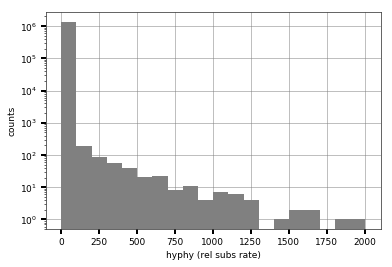

In [11]:
hyphy = []
for key, val in dicty_hyphy.items():
    hyphy.extend(dicty_hyphy[key])   
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(hyphy, 20, color='gray', alpha=1)
ax.set_xlabel('hyphy (rel subs rate)')
ax.set_yscale('log')
ax.set_ylabel('counts')

# Look at length and position-dependent scores

In [12]:
ivals = []
plot_vals_hyphy = []

length_to_analyze = 150

for i in range(length_to_analyze):
    tempy = []
    for gene_name, vals in dicty_hyphy.items():
        if len(vals) > i:
            tempy.extend([vals[i]])
    plot_vals_hyphy.append(np.median(tempy))
    ivals.append(i)
    
ivals_r = []
plot_vals_hyphy_r = []
for i in range(length_to_analyze, 0, -1):
    tempy = []
    for gene_name, vals in dicty_hyphy.items():
        if len(vals) > i:
            tempy.extend([vals[-i]])
    plot_vals_hyphy_r.append(np.median(tempy))
    ivals_r.append(-i)

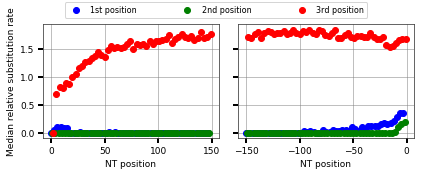

In [13]:
fig = plt.figure(figsize=(6,2.5))
ax1 = fig.add_subplot(121)
l1, = ax1.plot(ivals[0::3], plot_vals_hyphy[0::3], 'bo', label='1st codon position')
l2, = ax1.plot(ivals[1::3], plot_vals_hyphy[1::3], 'go', label='2nd codon position')
l3, = ax1.plot(ivals[2::3], plot_vals_hyphy[2::3], 'ro', label='3rd codon position')
ax1.set_ylabel('Median relative substitution rate')
ax1.set_xlabel('NT position')
ax2 = fig.add_subplot(122, sharey=ax1)
ax2.plot(ivals_r[0::3], plot_vals_hyphy_r[0::3], 'bo')
ax2.plot(ivals_r[1::3], plot_vals_hyphy_r[1::3], 'go')
ax2.plot(ivals_r[2::3], plot_vals_hyphy_r[2::3], 'ro')
ax2.set_xlabel('NT position')
plt.setp(ax2.get_yticklabels(), visible=False);
fig.subplots_adjust(top=0.85, left=0.1, right=0.9, bottom=0.18)  # create some space below the plots by increasing the bottom-value
plt.figlegend((l1, l2, l3), ('1st position', '2nd position', '3rd position'), bbox_to_anchor=(0.15, 0.88, 0.7, 0.85), loc=3,
           ncol=3, mode="expand", borderaxespad=0, fontsize=8)
plt.tight_layout()
# plt.savefig('../Results/Figures/position_dependent_rates.pdf')

# Defining SD threshold strength

In [ ]:
with open('../Data/json-energyRef-CCUCCU.txt') as infile:
    fragment_energy_dict = json.load(infile)
asd_seq = 'CCTCCT'

In [ ]:
real_utrs = []
include = 20
genome = list(SeqIO.parse('/Users/adamhockenberry/Projects/2017/Genome_database/Data/GBFs/511145.12.PATRIC.gbf', 'genbank'))
for record in genome:
    for feature in record.features[:]:
        if feature.type == 'CDS':
            if feature.location.strand == 1:
                cds = str(record.seq[feature.location.start:feature.location.end])
            elif feature.location.strand == -1:
                cds = str(record.seq[feature.location.start:feature.location.end].reverse_complement())
            if len(cds)%3 != 0 or len(cds) < 100 or cds[-3:] not in ['TAA', 'TGA', 'TAG']:
                continue
            if feature.location.strand == 1:
                real_utrs.append(record.seq[feature.location.start-include:feature.location.start])
            elif feature.location.strand == -1:
                real_utrs.append(record.seq[feature.location.end:feature.location.end+include].reverse_complement())

In [ ]:
randomizations = 20
real_utrs = [str(i) for i in real_utrs]
strongest_real = []
strongest_fake = []
strongest_fake_dict = {}
for randomization in range(randomizations):
    strongest_fake_dict[randomization] = []


for utr in real_utrs[:]:
    energy_list = []
    for i in range(0, len(utr)-len(asd_seq)-4):
        fragment = utr[i:i+len(asd_seq)]
        energy = fragment_energy_dict[fragment.replace('T', 'U')]
        energy_list.append(energy)
    strongest_real.append(min(energy_list))
    
    for randomization in range(randomizations):
        energy_list = []
        utr_rand = np.array(list(utr))
        np.random.shuffle(utr_rand)
        utr_rand = ''.join(list(utr_rand))
        for i in range(0, len(utr_rand)-len(asd_seq)-4):
            fragment = utr_rand[i:i+len(asd_seq)]
            energy = fragment_energy_dict[fragment.replace('T', 'U')]
            energy_list.append(energy)
        strongest_fake.append(min(energy_list))
        strongest_fake_dict[randomization].append(min(energy_list))        

In [ ]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
ax.hist(strongest_fake, 60, normed=True, alpha=0.7, color='gray', label='Shuffled UTRs')
ax.hist(strongest_real, 60, normed=True, alpha=0.7, label='Real UTRs')
ax.axvline(-4.5, c='r')
ax.axvline(-3.5, c='r', linestyle='--')
ax.axvline(-5.5, c='r', linestyle=':')
ax.set_xlabel('UTR binding strength to "5-CCUCCU-3"')
ax.set_ylabel('Probability density')
fig.subplots_adjust(top=0.8, left=0.2, right=0.9, bottom=0.25)  # create some space below the plots by increasing the bottom-value
ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.15, 0.9, 0.7, 0.4), fontsize=8)
plt.savefig('../Results/Figures/SD_threshold.pdf')

# Actually dig into data to test for conservation of SD motifs
The below analysis is limited to ONLY 4-fold redundant codon sites that are within an aSD sequence binding site. Critically, for each one that I find, I compare the conservation at that site to the same synonymous codon or nucleotide context somewhere else in the same gene. With these paired lists, we can accurately compare whether there are conservation differences while ruling out gene-specific effects.

## Positive control data. Find genes that have another gene directly 3' of them which are thus likely to contain a real SD sequence in their 3' terminus

In [14]:
preceding_genes = []
starts_positive_strand = []
starts_negative_strand = []
genome = list(SeqIO.parse('/Users/adamhockenberry/Projects/2017/Genome_database/Data/GBFs/511145.12.PATRIC.gbf', 'genbank'))
for record in genome:
    for feature in record.features:
        if feature.type == 'CDS':
            if feature.location.strand == 1:
                starts_positive_strand.append(feature.location.start)
            elif feature.location.strand == -1:
                starts_negative_strand.append(feature.location.end)
for i,j in enumerate(starts_positive_strand):
    starts_positive_strand[i] = list(range(j-20,j+20,1)) #####Giving flexibility to mis-annotated starts
for i,j in enumerate(starts_negative_strand):
    starts_negative_strand[i] = list(range(j-20,j+20,1))
for record in genome:
    for feature in record.features:
        if feature.type == 'CDS':
            if feature.location.strand == 1:
                end = feature.location.end
                for i in starts_positive_strand:
                    if end in i:
                        preceding_genes.append(feature.qualifiers['locus_tag'][0])
            elif feature.location.strand == -1:
                end = feature.location.start
                for i in starts_negative_strand:
                    if end in i:
                        preceding_genes.append(feature.qualifiers['locus_tag'][0])
                        
preceding_genes = [i for i in seq_dicty[base_genome].keys() if i in preceding_genes]
not_preceding_genes = [i for i in seq_dicty[base_genome].keys() if i not in preceding_genes]
print(len(preceding_genes), len(not_preceding_genes), len(seq_dicty[base_genome].keys()))

391 1003 1394


In [15]:
three_prime_limitation_dict = {}
for gene_name, nts in seq_dicty[base_genome].items():
    three_prime_limitation_dict[gene_name] = list(range(len(nts)-50, len(nts))) ### Again giving a lot of padding (maybe too much)

## Comparing conservation of a particular 4-fold redundant position that is within a strong binding sequence to a randomly chosen identical 4-fold redundant codon elsewhere in the sequence
Note I'm currently looking at a 6nt aSD sequence and only considering 4-fold redundant codons in positions 2,3,4, or 5. I'm also taking care not to double count any one position

In [16]:
def get_sd_sites(nt_sequence, asd_seq, threshold, fragment_energy_dict,\
                 position_limitation_list, upper_threshold=-20, min_position=100, max_position=-50):
    codon_list = [nt_sequence[nt:nt+3] for nt in range(0, len(nt_sequence), 3)]
    energy_list = []
    for i in range(0, len(nt_sequence)-len(asd_seq)):
        fragment = nt_sequence[i:i+len(asd_seq)]
        if fragment.count('-') == 0:
            energy = fragment_energy_dict[fragment.replace('T', 'U')]
            energy_list.append(energy)
        else:
            energy_list.append(np.nan)
    #######This gets all positions below the given threshold
    sd_positions_all_nts = [list(range(i, i+len(asd_seq))) for i,j in enumerate(energy_list) if j < threshold]
    sd_positions_all_nts = [item for sublist in sd_positions_all_nts for item in sublist]
    sd_positions_all_nts = list(set(sd_positions_all_nts))
    
    #######This gets all "start" position within the threshold range. Subtle but important difference
    if position_limitation_list != False:
        sd_positions_start = np.array([i for i,j in enumerate(energy_list) if upper_threshold < j and j < threshold and i in position_limitation_list])
    else:
        sd_positions_start = np.array([i for i,j in enumerate(energy_list) if upper_threshold < j and j < threshold and i > min_position and i < len(nt_sequence)+max_position])
    
    ###THIS IS REALLY IMPORTANT: SHUFFLE THE SEQUENCES SO THAT WHEN I ITERATE THROUGH THEM
    ###I'M NOT SELECTING THE SAME ONES EVERY TIME
    np.random.shuffle(sd_positions_start) 
    return sd_positions_all_nts, sd_positions_start, energy_list, codon_list

def get_control_sites_codon(nt_sequence, codon_list, sd_positions_all_nts,\
                            analyzed_positions, codon, min_position=100, max_position=-50):
    control_sites = [site*3+2 for site, x in enumerate(codon_list) if x == codon]
    control_sites = [site for site in control_sites if site > min_position and site < len(nt_sequence)+max_position]
    control_sites = [site for site in control_sites if site not in sd_positions_all_nts]
    control_sites = [site for site in control_sites if site not in analyzed_positions]
    return control_sites

def get_control_sites_tri_nt(nt_sequence, codon_list, sd_positions_all_nts,\
                             analyzed_positions, tri_nt, redundant_codons, min_position=100, max_position=-50):
    control_sites = [m.start()+1 for m in re.finditer(tri_nt, nt_sequence)]
    control_sites = [site for site in control_sites if site > min_position and site < len(nt_sequence)+max_position]
    control_sites = [site for site in control_sites if site%3 == 2]
    control_sites = [site for site in control_sites if nt_sequence[site-2:site+1] in redundant_codons]
    control_sites = [site for site in control_sites if site not in sd_positions_all_nts]
    control_sites = [site for site in control_sites if site not in analyzed_positions]
    return control_sites

def get_possible_energies(fragment, codon, all_codons, modifier, fragment_energy_dict):
    possible_energies = []
    for possible_codon in all_codons:
        if possible_codon != codon:
            if modifier == 2:
                possible_fragment = possible_codon + fragment[-3:]
            elif modifier == 3:
                possible_fragment = fragment[0] + possible_codon + fragment[-2:]
            elif modifier == 1:
                possible_fragment = possible_codon[-2:] + fragment[-4:]
            elif modifier == 4:
                possible_fragment = fragment[0:2] + possible_codon + fragment[-1]
            assert len(possible_fragment) == 6
            possible_energies.append(fragment_energy_dict[possible_fragment.replace('T', 'U')])
    return possible_energies


def paired_nt_analysis(dicty_to_analyze,\
                      genome_seq_dicty,\
                      fragment_energy_dict,\
                      asd_seq,\
                      conservation_dicty,\
                      nt_conservation_dicty,\
                      redundant_codons=redundant_codons,\
                      threshold=-4.5,\
                      upper_threshold=-20,\
                      min_position=100,\
                      max_position=-50,\
                      subset_names=False,\
                      only_conserved_aa=False,\
                      position_limitation_dict=False,\
                      internal_control='',\
                      nt_strength_restriction=''):
    '''
    This is my rather monsterous main function that has a lot of flags so be careful! 
    However, its complexity provides the benefit that I know all analyses are run through
    a common function. For the most part, all of these flags are ultimately limiting the 
    data according to various criteria at different points in the pipeline noted as comments below.
    '''
    sds = []
    others = []
    analyzed_sd_dict = {}
    analyzed_control_dict = {}
    
    all_sds = []
    all_others = []
        
    for gene_name, seq in list(genome_seq_dicty.items())[:]:

        analyzed_sds = []
        analyzed_controls = []
        
        gene_sds = []
        gene_others = []
        
        ###########Skip ahead if this gene is not in my dictionary to analyze
        if gene_name not in dicty_to_analyze.keys():
            continue
        ###########Skip ahead if I want to only analyze a subset and this gene isn't in it
        if subset_names:
            if gene_name not in subset_names:
                continue
        ###########Hang on to this information for now to eventually limit where in the gene to consider, if relevant
        position_limitation_list = False
        if position_limitation_dict != False:
            position_limitation_list = position_limitation_dict[gene_name]
            
        ##################################################################################################
        ###GET LOCATIONS OF ALL SD-LIKE SEQUENCES THAT I MIGHT WANT TO ANALYZE FOR THIS GENE       
        sd_positions_all_nts, sd_positions_start, energy_list, codon_list =\
                        get_sd_sites(seq, asd_seq, threshold, fragment_energy_dict,\
                                     position_limitation_list=position_limitation_list,\
                                     upper_threshold=upper_threshold, min_position=min_position,\
                                     max_position=max_position)

        for i in sd_positions_start:
            energy = energy_list[i]
            modifiers = []
            ###This accounting below is to determine the frame. Analysis is only done on the internal
            ###4 sites of a given 6-mer so depending on the frame there are only a few possible 3rd-position
            ###codon sites
            if i%3 == 0:
                modifiers = [2]
            elif i%3 == 2:
                modifiers = [3]
            elif i%3 == 1:
                modifiers = [1,4]
            for modifier in modifiers:
                ##################################################################################################
                #If I'm only considering particular regions, make sure that this location is one of them. Otherwise, meh.
                if position_limitation_dict != False:
                    if i+modifier not in position_limitation_dict[gene_name]:
                        continue

                analyzed_positions = analyzed_sds + analyzed_controls
                
                ##################################################################################################
                #Make sure that the location is conserved, and if TRINT that the next position is conserved
                if only_conserved_aa == True:
                    if conservation_dicty[gene_name][int(np.floor((i+modifier)/3.))] != 'C':
                        continue
                if only_conserved_aa == True and internal_control=='TRINT':
                    if nt_conservation_dicty[gene_name][i+modifier+1] != 'C':
                        continue
                
                codon = seq[i+modifier-2:i+modifier+1]
                tri_nt = seq[i+modifier-1:i+modifier+2]
                if codon in redundant_codons:
                    ##################################################################################################
                    ###RUN A FILTER ACCORDING TO WHETHER I ONLY WANT TO SELECT STRONGEST OR WEAKEST POSSIBLE SEQUENCES
                    if nt_strength_restriction == 'None':
                        pass
                    else:
                        fragment = genome_seq_dicty[gene_name][i:i+len(asd_seq)]
                        all_codons = aa_to_codon_dict[codon_to_aa_dict[codon]]
                        all_codons = [temp for temp in all_codons if temp[:2] == codon[:2]]###Dealing with 6-fold redundant codons
                        possible_energies = get_possible_energies(fragment, codon, all_codons, modifier, fragment_energy_dict)
                        possible_energies = sorted(possible_energies)
                        assert len(possible_energies) == 3, possible_energies
                        if energy in possible_energies:###Because I don't know how to treat these cases, toss them and move on
                            continue
                        insertion_point = bisect(possible_energies, energy)
                        #################################################################
                        ###Below will get rid of the ones that aren't included in my flag
                        if int(nt_strength_restriction) != insertion_point:
                            continue 
                            
                    ##################################################################################################
                    ###GET CONTROL SITES ACCORDING TO EITHER OF TWO DIFFERENT NULL MODELS
                    if internal_control == 'CODON':
                        control_sites =\
                            get_control_sites_codon(seq, codon_list, sd_positions_all_nts, analyzed_positions, codon,\
                                                   min_position=min_position, max_position=max_position)
                    elif internal_control == 'TRINT':
                        control_sites =\
                            get_control_sites_tri_nt(seq, codon_list, sd_positions_all_nts, analyzed_positions, tri_nt, redundant_codons,\
                                                    min_position=min_position, max_position=max_position)
                    else:
                        print("YOU DID NOT PROPERLY SPECIFY A CONTROL METHOD, VALID VALUES ARE 'CODON' AND 'TRINT'")
                        break
                    ##################################################################################################
                    ###Limit the controls based on conservation of the amino acid
                    if only_conserved_aa == True and internal_control == 'CODON':
                        control_sites = [site for site in control_sites if conservation_dicty[gene_name][int(np.floor(site/3.))] == 'C']
                    elif only_conserved_aa == True and internal_control == 'TRINT':
                        control_sites = [site for site in control_sites if conservation_dicty[gene_name][int(np.floor(site/3.))] == 'C']
                        control_sites = [site for site in control_sites if nt_conservation_dicty[gene_name][site+1] == 'C']

                    ##################################################################################################
                    ###IF ALL LOOKS WELL CHOOSE A CONTROL AND GO FORWARD WITH ANALYSIS
                    ##################################################################################################                    
                    ###First keep track of all the sites that I could potentially analyze
                    gene_sds.append(i+modifier)
                    gene_others.extend(control_sites)
                    if len(control_sites) > 0 and i+modifier not in analyzed_positions:
                        choice = random.choice(control_sites)
                        sds.append(dicty_to_analyze[gene_name][i+modifier])
                        others.append(dicty_to_analyze[gene_name][choice])
                        analyzed_sds.append(i+modifier)
                        analyzed_controls.append(choice)
                        #######################################################################
                        ###Fail safe to make sure I chose the right codons and context controls
                        if internal_control == 'CODON':
                            assert seq_dicty[base_genome][gene_name][i+modifier-2:i+modifier+1] == seq_dicty[base_genome][gene_name][choice-2:choice+1]
                        if internal_control == 'TRINT':
                            assert seq_dicty[base_genome][gene_name][i+modifier-1:i+modifier+2] == seq_dicty[base_genome][gene_name][choice-1:choice+2]
        gene_sds = list(set(gene_sds))
        gene_others = list(set(gene_others))
        
        all_sds.extend([dicty_to_analyze[gene_name][position] for position in gene_sds])
        all_others.extend([dicty_to_analyze[gene_name][position] for position in gene_others])
        analyzed_sd_dict[gene_name] = analyzed_sds
        analyzed_control_dict[gene_name] = analyzed_controls
    return sds, others, analyzed_sd_dict, analyzed_control_dict, all_sds, all_others

# Main function
There are a lot of flags at the top here but the analysis below is essentially the analysis that is used throughout the manuscript. Thresholds, null models, etc can all be altered below to accomplish various analyses that were depicted in the manuscript.

This isn't optimized for speed in anyway, and will take a little while to run but nothing too long. Each iteration is printed to the screen to check progress.

In [25]:
dicty_to_analyze = dicty_hyphy #####If this changes, make sure to manually change file_name_modifiers
threshold=-4.5
upper_threshold=-20.0
# subset_names=preceding_genes
# subset_names=not_preceding_genes
subset_names=False ###Changing this requires manual tinkering of file_name_modifiers below
only_conserved_aa=True
# position_limitation_dict=three_prime_limitation_dict
position_limitation_dict=False
controls=('CODON', 'TRINT')
nt_strength_restriction='3' ###Valid values are: 'None', '0', '1', '2', '3'


mean_randomizations = 100

#########################################################
####Putative aSD sequence to use in considering hybridization energies
with open('../Data/json-energyRef-CCUCCU.txt') as infile:
    fragment_energy_dict = json.load(infile)
asd_seq = 'CCUCCU'
#########################################################
#########################################################
#
#
#
#########################################################
####For writing files later
file_name_modifiers = '{}_{}_Threshold={}to{}_Conserved={}_NtRestriction={}'.format('hyphy', species_name, upper_threshold, threshold, only_conserved_aa, nt_strength_restriction)
if subset_names != False or position_limitation_dict != False:
    file_name_modifiers = file_name_modifiers + '_Subset=preceding_Position_limitation=3prime'
#########################################################
#########################################################
#
#
#########################################################
#These containers are for keeping track of randomizations to assess significance
actual_ratios_codon = []
shuffled_ratios_codon = []
actual_ratios_trint = []
shuffled_ratios_trint = []

actual_pvals_codon = []
shuffled_pvals_codon = []
actual_pvals_trint = []
shuffled_pvals_trint = []



for i in range(mean_randomizations):
    print('#####{}'.format(i))
    sds_codon, others_codon, analyzed_sd_dict, analyzed_ctrl_dict, all_sds_codon, all_others_codon = paired_nt_analysis(dicty_to_analyze,\
                                     seq_dicty[base_genome],\
                                     fragment_energy_dict,\
                                     asd_seq,\
                                     conservation_dicty,\
                                     nt_conservation_dicty,\
                                     threshold=threshold,\
                                     upper_threshold=upper_threshold,\
                                     subset_names=subset_names,\
                                     only_conserved_aa=only_conserved_aa,\
                                     position_limitation_dict=position_limitation_dict,\
                                     internal_control=controls[0],\
                                     nt_strength_restriction=nt_strength_restriction)
    actual_ratios_codon.append(np.mean(sds_codon)/np.mean(others_codon))
    print('Lengths:{}, {}, Means:{}, {}, Ratio:{}'.format(len(sds_codon), len(others_codon),\
                                                          np.mean(sds_codon), np.mean(others_codon),\
                                                          np.mean(sds_codon)/np.mean(others_codon)))
    t_val, p_val = stats.wilcoxon(sds_codon, others_codon)
    actual_pvals_codon.append(p_val)

    combined = sds_codon + others_codon
    random.shuffle(combined)
    random_sds = combined[:len(sds_codon)]
    random_others = combined[len(sds_codon):]
    shuffled_ratios_codon.append(np.mean(random_sds)/np.mean(random_others))
    t_val_rand, p_val_rand = stats.wilcoxon(random_sds, random_others)
    shuffled_pvals_codon.append(p_val_rand)


    sds_trint, others_trint, analyzed_sd_dict, analyzed_ctrl_dict, all_sds_trint, all_others_trint = paired_nt_analysis(dicty_to_analyze,\
                                     seq_dicty[base_genome],\
                                     fragment_energy_dict,\
                                     asd_seq,\
                                     conservation_dicty,\
                                     nt_conservation_dicty,\
                                     threshold=threshold,\
                                     upper_threshold=upper_threshold,\
                                     subset_names=subset_names,\
                                     only_conserved_aa=only_conserved_aa,\
                                     position_limitation_dict=position_limitation_dict,\
                                     internal_control=controls[1],\
                                     nt_strength_restriction=nt_strength_restriction)
    actual_ratios_trint.append(np.mean(sds_trint)/np.mean(others_trint))
    print('Lengths:{}, {}, Means:{}, {}, Ratio:{}'.format(len(sds_trint), len(others_trint),\
                                                          np.mean(sds_trint), np.mean(others_trint),\
                                                          np.mean(sds_trint)/np.mean(others_trint)))
    t_val, p_val = stats.wilcoxon(sds_trint, others_trint)
    actual_pvals_trint.append(p_val)

    combined = sds_trint + others_trint
    random.shuffle(combined)
    random_sds = combined[:len(sds_trint)]
    random_others = combined[len(sds_trint):]
    shuffled_ratios_trint.append(np.mean(random_sds)/np.mean(random_others))
    
    t_val_rand, p_val_rand = stats.wilcoxon(random_sds, random_others)
    shuffled_pvals_trint.append(p_val_rand)

#####0
Lengths:390, 390, Means:2.426463662264939, 2.610743436276448, Ratio:0.929414828186129
Lengths:293, 293, Means:2.3392532812794777, 2.2567964950585773, Ratio:1.0365370942401966
#####1
Lengths:390, 390, Means:2.426463662264939, 2.5981880305183105, Ratio:0.9339061044711554
Lengths:293, 293, Means:2.324325786149074, 2.348858896874692, Ratio:0.9895553067243582
#####2
Lengths:390, 390, Means:2.426463662264939, 2.6114613026684985, Ratio:0.9291593407053279
Lengths:293, 293, Means:2.338215137688884, 2.360067566256971, Ratio:0.9907407614593234
#####3
Lengths:390, 390, Means:2.426463662264939, 2.6080041508892964, Ratio:0.93039102772806
Lengths:293, 293, Means:2.3483589382481806, 2.395094154931354, Ratio:0.980487106702278
#####4
Lengths:390, 390, Means:2.4407340736525622, 2.736841160348337, Ratio:0.8918069886605743
Lengths:293, 293, Means:2.351027658307048, 2.3224714984920425, Ratio:1.0122955910690603
#####5
Lengths:390, 390, Means:2.426463662264939, 2.655547414799215, Ratio:0.91373388731166

In [26]:
df = pd.DataFrame({'Actual_rats_codon':actual_ratios_codon})
df['Shuffled_rats_codon'] = shuffled_ratios_codon
df['Actual_rats_trint'] = actual_ratios_trint
df['Shuffled_rats_trint'] = shuffled_ratios_trint

df['Actual_pvals_codon'] = actual_pvals_codon
df['Shuffled_pvals_codon'] = shuffled_pvals_codon
df['Actual_pvals_trint'] = actual_pvals_trint
df['Shuffled_pvals_trint'] = shuffled_pvals_trint

df['N_(codon)'] = len(sds_codon)
df['N_(trint)'] = len(sds_trint)
df.to_csv('../Results/Dataframes/df_{}_ratios.csv'.format(file_name_modifiers), index=False)


dfA = pd.DataFrame({'SD-like(codon)':all_sds_codon})
dfB = pd.DataFrame({'SD-like(trint)':all_sds_trint})
dfC = pd.DataFrame({'Control\n(codon)':all_others_codon})
dfD = pd.DataFrame({'Control\n(context)':all_others_trint})

df = pd.concat([dfA,dfB,dfC,dfD], axis=1)
df.to_csv('../Results/Dataframes/df_{}_all.csv'.format(file_name_modifiers), index=False)

# Put rates into context
Similar paired analysis of 2-fold vs 4-fold redundant codons

In [ ]:
genome_seq_dicty = seq_dicty[base_genome]
dicty_to_analyze = dicty_hyphy

ratios_all = []
for randomization in range(10):
    two_fold = []
    four_fold = []
    two_fold_all = []
    four_fold_all = []
    for gene_name, nt_sequence in list(genome_seq_dicty.items())[:]:
        if gene_name not in dicty_to_analyze.keys():
            continue
        two_fold_gene = []
        four_fold_gene = []
        codon_list = [nt_sequence[nt:nt+3] for nt in range(0, len(nt_sequence), 3)]
        for i, codon in enumerate(codon_list):
            if codon == '---':
                continue
            if i < 33:
                continue
            if i > len(codon_list)-16:
                continue
            if conservation_dicty[gene_name][i] != 'C':
                continue
            if codon in redundant_codons:
                four_fold_gene.append(dicty_to_analyze[gene_name][i*3+2])
            elif codon_to_aa_dict[codon] in ['F', 'D', 'E', 'K', 'N', 'Q', 'H', 'Y', 'C']:
                two_fold_gene.append(dicty_to_analyze[gene_name][i*3+2])
        smallest_set = min([len(two_fold_gene), len(four_fold_gene)])
        two_fold_truncated = random.sample(two_fold_gene, smallest_set)
        four_fold_truncated = random.sample(four_fold_gene, smallest_set)
        two_fold.extend(two_fold_truncated)
        four_fold.extend(four_fold_truncated)
        two_fold_all.extend(two_fold_gene)
        four_fold_all.extend(four_fold_gene)
    ratio_i = np.mean(four_fold)/np.mean(two_fold)
    ratios_all.append(ratio_i)
    print(randomization, 'Ratio:', ratio_i, 'Lengths:', len(four_fold), len(two_fold), len(two_fold_all), len(four_fold_all))
print(np.mean(four_fold_all)/np.mean(two_fold_all))

In [ ]:
plt.figure()
plt.boxplot([two_fold, four_fold], showmeans=True);
plt.ylim(0,10)

# Testing gene expression differences systematically

### First, tediously get a dictionary linking names in PATRIC annotations to names in RefSeq

In [27]:
genome_ref = list(SeqIO.parse('/Users/adamhockenberry/Projects/2017/Genome_database/Data/GBFs/511145.12.RefSeq.gbf', 'genbank'))[0]
genome_pat = list(SeqIO.parse('/Users/adamhockenberry/Projects/2017/Genome_database/Data/GBFs/511145.12.PATRIC.gbf', 'genbank'))[0]

locs_dict_ref_positive = {}
locs_dict_ref_negative = {}

locs_dict_pat_positive = {}
locs_dict_pat_negative = {}

ref_genome_seq_ref_dict = {}
ref_genome_seq_patric_dict = {}

for feature_pat in genome_pat.features[:]:
    if feature_pat.type == 'CDS':
        name_pat = feature_pat.qualifiers['locus_tag'][0]
        strand_pat = feature_pat.strand
        if strand_pat == 1:
            locs_dict_pat_positive[name_pat] = list(range(feature_pat.location.start, feature_pat.location.end))
            ref_genome_seq_patric_dict[name_pat] = genome_pat.seq[feature_pat.location.start:feature_pat.location.end]
        elif strand_pat == -1:
            locs_dict_pat_negative[name_pat] = list(range(feature_pat.location.start, feature_pat.location.end))
            ref_genome_seq_patric_dict[name_pat] = genome_pat.seq[feature_pat.location.start:feature_pat.location.end].reverse_complement()

for feature_ref in genome_ref.features[:]:
    if feature_ref.type == 'CDS':
        name_ref = feature_ref.qualifiers['locus_tag'][0]
        strand_ref = feature_ref.strand
        if strand_ref == 1:
            locs_dict_ref_positive[name_ref] = list(range(feature_ref.location.start, feature_ref.location.end))
            ref_genome_seq_ref_dict[name_ref] = genome_ref.seq[feature_ref.location.start:feature_ref.location.end]

        elif strand_ref == -1:
            locs_dict_ref_negative[name_ref] = list(range(feature_ref.location.start, feature_ref.location.end))
            ref_genome_seq_ref_dict[name_ref] = genome_ref.seq[feature_ref.location.start:feature_ref.location.end].reverse_complement()
            
print(len(locs_dict_pat_positive.keys()))
print(len(locs_dict_pat_negative.keys()))
print(len(locs_dict_ref_positive.keys()))
print(len(locs_dict_ref_negative.keys()))   

reference_name_dict = {}
for name_pat, loc_pat in sorted(locs_dict_pat_positive.items()):
    for name_ref, loc_ref in sorted(locs_dict_ref_positive.items()):
        if len(set(loc_pat)&set(loc_ref)) / len(loc_pat) > 0.9: #######Make sure that 90% of the location matches
#         if loc_pat == loc_ref:
            reference_name_dict[name_ref] = name_pat
            del locs_dict_ref_positive[name_ref]
            break
            
for name_pat, loc_pat in sorted(locs_dict_pat_negative.items()):
    for name_ref, loc_ref in sorted(locs_dict_ref_negative.items()):
        if len(set(loc_pat)&set(loc_ref)) / len(loc_pat) > 0.9: ######Again stick with that 90% cutoff
#         if loc_pat == loc_ref:
            reference_name_dict[name_ref] = name_pat
            del locs_dict_ref_negative[name_ref]
            break
print(len(reference_name_dict.keys()), len(ref_genome_seq_patric_dict.keys()), len(ref_genome_seq_ref_dict.keys()))

2246
2303
2108
2213
4139 4549 4321


### Load in dataset of protein abundance from PaxDB (integrated dataset)

In [28]:
df = pd.read_csv('../Data/511145-WHOLE_ORGANISM-integrated.txt',\
                 index_col = 'string_external_id', sep='\t', skiprows=10)
expression_dict = {}
for index in df.index:
    temp_name = index.split('.')[-1]
    try:
        expression_dict[reference_name_dict[temp_name]] = df.loc[index]['abundance']
    except KeyError:
        pass

### Get list of gene expression values in my dataset

In [29]:
dict_to_analyze = dicty_hyphy

full_listy = []
for key in expression_dict.keys():
    if key in dict_to_analyze.keys():
        full_listy.append(expression_dict[key])
print(len(full_listy))
full_listy_to_plot = sorted(full_listy)[:-1]

1347


In [30]:
percentile_20 = np.percentile(full_listy, 20)
percentile_40 = np.percentile(full_listy, 40)
percentile_60 = np.percentile(full_listy, 60)
percentile_80 = np.percentile(full_listy, 80)

expression_quantile_dict = {}
expression_quantile_dict['lowest'] = []
expression_quantile_dict['low'] = []
expression_quantile_dict['mid'] = []
expression_quantile_dict['high'] = []
expression_quantile_dict['highest'] = []

for seq_name in dict_to_analyze:
    if seq_name not in expression_dict.keys():
        continue
    if expression_dict[seq_name] < percentile_20:
        expression_quantile_dict['lowest'].append(seq_name)
    elif expression_dict[seq_name] >= percentile_20 and expression_dict[seq_name] < percentile_40:
        expression_quantile_dict['low'].append(seq_name)
    elif expression_dict[seq_name] >= percentile_40 and expression_dict[seq_name] < percentile_60:
        expression_quantile_dict['mid'].append(seq_name)
    elif expression_dict[seq_name] >= percentile_60 and expression_dict[seq_name] < percentile_80:
        expression_quantile_dict['high'].append(seq_name)
    elif expression_dict[seq_name] >= percentile_80 :
        expression_quantile_dict['highest'].append(seq_name)
    
for key, vals in expression_quantile_dict.items():
    print(key, len(vals))

mid 268
highest 270
low 269
high 270
lowest 270


# Visualize some differences between the categories

In [ ]:
fig, ax = plt.subplots(figsize=(5,2))
ax.hist(full_listy_to_plot, 10000, cumulative=True, histtype='step')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.axvspan(percentile_20, percentile_40, color='k', alpha=0.2)
ax.axvspan(percentile_60, percentile_80, color='k', alpha=0.2)
ax.set_xlabel('Protein abundance')
ax.set_ylabel('Cumulative\ncounts')
plt.tight_layout()

In [ ]:
asd_seq = 'CCUCCU'
threshold = -4.5
upper_threshold = -20

density_dict = {}
eligible_density_dict = {}
exp_energy_dict = {}
basic_conservation_dict = {}
for category in ['lowest', 'low', 'mid', 'high', 'highest'][:]:
    lengths = []
    sd_nts = []
    energies_temp = []
    cons = []
    eligible_sites = []
    
    for gene_name in expression_quantile_dict[category]:
        if gene_name in seq_dicty[base_genome].keys():
            seq = seq_dicty[base_genome][gene_name]
            sd_positions_all_nts, sd_positions_start, energy_list, codon_list =\
                get_sd_sites(seq, asd_seq, threshold, fragment_energy_dict,\
                             position_limitation_list=False, upper_threshold=upper_threshold)
            sd_nts.append(len([i for i in sd_positions_all_nts if i > 100 and i < (len(seq)-50)]))
            lengths.append(len(seq)-150)
            energies_temp.extend([i for i in energy_list if i < threshold])
            cons.append(conservation_dicty[gene_name].count('C')/len(conservation_dicty[gene_name]))
            
            eligible_sites_ind = []
            for i in sd_positions_start:
                modifiers = []
                if i%3 == 0:
                    modifiers = [2]
                elif i%3 == 2:
                    modifiers = [3]
                elif i%3 == 1:
                    modifiers = [1,4]
                for modifier in modifiers:
                    if conservation_dicty[gene_name][int(np.floor((i+modifier)/3.))] != 'C':
                        continue
                    codon = seq[i+modifier-2:i+modifier+1]
                    if codon in redundant_codons:
                        eligible_sites_ind.append(i+modifier)
                        
            eligible_sites_ind = list(set(eligible_sites_ind))
            eligible_sites.append(len(eligible_sites_ind))
            
            
            
    density_dict[category] = np.array(sd_nts)/np.array(lengths)
    exp_energy_dict[category] = energies_temp
    basic_conservation_dict[category] = cons
    eligible_density_dict[category] = np.array(eligible_sites)/np.array(lengths)

In [ ]:
fig = plt.figure(figsize=(3.5,3.5))
ax = fig.add_subplot(311)
boxes = ax.bar([0, 1, 2, 3, 4], [np.mean(density_dict[i]) for i in ['lowest', 'low', 'mid', 'high', 'highest']], facecolor='0.3')
# ax.set_ylim(-0.01, 0.18)

ax.set_xticklabels('')
ax.set_ylabel('SD-like nt\nfraction')

for line in ax.xaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)

ax = fig.add_subplot(312)
boxes = ax.bar([0, 1, 2, 3, 4], [np.mean(basic_conservation_dict[i]) for i in ['lowest', 'low', 'mid', 'high', 'highest']], facecolor='0.3')
# ax.set_ylim(-0.01, 0.18)
ax.set_xticklabels('')
ax.set_ylabel('Conserved AA\nfraction')
for line in ax.xaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)

ax = fig.add_subplot(313)
boxes = ax.bar([0, 1, 2, 3, 4], [np.mean(eligible_density_dict[i]) for i in ['lowest', 'low', 'mid', 'high', 'highest']], facecolor='0.3')
ax.set_xticklabels('')
ax.set_ylabel('Eligible SD-like\nnt fraction')
ax.set_xticklabels(['', 'Lowest 20%', '', '', '', 'Highest 20%'], ha='center')
ax.set_xlabel('Gene expression bins')
plt.tight_layout(h_pad=-0.1)
plt.savefig('../Results/Figures/expression_summary.pdf')

In [31]:
#####Parameters!
dicty_to_analyze = dicty_hyphy
threshold=-4.5
upper_threshold=-20
only_conserved_aa=True
position_limitation_dict=False
controls=('CODON', 'TRINT')
nt_strength_restriction='0'

randomizations=100


meta_codon = []
meta_trint = []
for cat in ['lowest', 'low', 'mid', 'high', 'highest']:
    file_name_modifiers = '{}_{}_Threshold={}to{}_Conserved={}_NtRestriction={}_Subset={}'.format('hyphy', species_name, upper_threshold, threshold, only_conserved_aa, nt_strength_restriction, cat)
    print('#####{}'.format(cat))
    subset_names = expression_quantile_dict[cat]
    actual_ratios_codon = []
    shuffled_ratios_codon = []
    actual_ratios_trint = []
    shuffled_ratios_trint = []

    actual_pvals_codon = []
    shuffled_pvals_codon = []
    actual_pvals_trint = []
    shuffled_pvals_trint = []
    for i in range(randomizations):
        print('#####{}'.format(i))
        sds_codon, others_codon, analyzed_sd_dict, analyzed_ctrl_dict, all_sds_codon, all_others_codon = paired_nt_analysis(dicty_to_analyze,\
                                         seq_dicty[base_genome],\
                                         fragment_energy_dict,\
                                         asd_seq,\
                                         conservation_dicty,\
                                         nt_conservation_dicty,\
                                         threshold=threshold,\
                                         upper_threshold=upper_threshold,\
                                         subset_names=subset_names,\
                                         only_conserved_aa=only_conserved_aa,\
                                         position_limitation_dict=position_limitation_dict,\
                                         internal_control=controls[0],\
                                         nt_strength_restriction=nt_strength_restriction)
        actual_ratios_codon.append(np.mean(sds_codon)/np.mean(others_codon))
        print('Lengths:{}, {}, Means:{}, {}, Ratio:{}'.format(len(sds_codon), len(others_codon),\
                                                              np.mean(sds_codon), np.mean(others_codon),\
                                                              np.mean(sds_codon)/np.mean(others_codon)))
        t_val, p_val = stats.wilcoxon(sds_codon, others_codon)
        actual_pvals_codon.append(p_val)

        combined = sds_codon + others_codon
        random.shuffle(combined)
        random_sds = combined[:len(sds_codon)]
        random_others = combined[len(sds_codon):]
        shuffled_ratios_codon.append(np.mean(random_sds)/np.mean(random_others))
        t_val_rand, p_val_rand = stats.wilcoxon(random_sds, random_others)
        shuffled_pvals_codon.append(p_val_rand)
        
        sds_trint, others_trint, analyzed_sd_dict, analyzed_ctrl_dict, all_sds_trint, all_others_trint = paired_nt_analysis(dicty_to_analyze,\
                                         seq_dicty[base_genome],\
                                         fragment_energy_dict,\
                                         asd_seq,\
                                         conservation_dicty,\
                                         nt_conservation_dicty,\
                                         threshold=threshold,\
                                         upper_threshold=upper_threshold,\
                                         subset_names=subset_names,\
                                         only_conserved_aa=only_conserved_aa,\
                                         position_limitation_dict=position_limitation_dict,\
                                         internal_control=controls[1],\
                                         nt_strength_restriction=nt_strength_restriction)
        actual_ratios_trint.append(np.mean(sds_trint)/np.mean(others_trint))
        print('Lengths:{}, {}, Means:{}, {}, Ratio:{}'.format(len(sds_trint), len(others_trint),\
                                                              np.mean(sds_trint), np.mean(others_trint),\
                                                              np.mean(sds_trint)/np.mean(others_trint)))
        
        t_val, p_val = stats.wilcoxon(sds_trint, others_trint)
        actual_pvals_trint.append(p_val)

        combined = sds_trint + others_trint
        random.shuffle(combined)
        random_sds = combined[:len(sds_trint)]
        random_others = combined[len(sds_trint):]
        shuffled_ratios_trint.append(np.mean(random_sds)/np.mean(random_others))

        t_val_rand, p_val_rand = stats.wilcoxon(random_sds, random_others)
        shuffled_pvals_trint.append(p_val_rand)
    
    df = pd.DataFrame({'Actual_rats_codon':actual_ratios_codon})
    df['Shuffled_rats_codon'] = shuffled_ratios_codon
    df['Actual_rats_trint'] = actual_ratios_trint
    df['Shuffled_rats_trint'] = shuffled_ratios_trint

    df['Actual_pvals_codon'] = actual_pvals_codon
    df['Shuffled_pvals_codon'] = shuffled_pvals_codon
    df['Actual_pvals_trint'] = actual_pvals_trint
    df['Shuffled_pvals_trint'] = shuffled_pvals_trint

    df['N_(codon)'] = len(sds_codon)
    df['N_(trint)'] = len(sds_trint)
    df.to_csv('../Results/Dataframes/df_{}_ratios.csv'.format(file_name_modifiers), index=False)


    dfA = pd.DataFrame({'SD-like(codon)':all_sds_codon})
    dfB = pd.DataFrame({'SD-like(trint)':all_sds_trint})
    dfC = pd.DataFrame({'Control\n(codon)':all_others_codon})
    dfD = pd.DataFrame({'Control\n(context)':all_others_trint})

    df = pd.concat([dfA,dfB,dfC,dfD], axis=1)
    df.to_csv('../Results/Dataframes/df_{}_all.csv'.format(file_name_modifiers), index=False)

#####lowest
#####0
Lengths:153, 153, Means:3.112197838666303, 2.998687732585244, Ratio:1.03785325989352
Lengths:77, 77, Means:2.9396803419275654, 2.3394556639866897, Ratio:1.2565659555684963
#####1
Lengths:153, 153, Means:3.214817830534783, 2.9594841847488436, Ratio:1.0862764015100181
Lengths:77, 77, Means:2.982366279914351, 2.4851718095109248, Ratio:1.2000644255260857
#####2
Lengths:153, 153, Means:3.1748584885574114, 2.830271038068987, Ratio:1.121750689546513
Lengths:77, 77, Means:3.130787980478956, 2.3792871555409176, Ratio:1.3158512511564369
#####3
Lengths:153, 153, Means:3.189543075147782, 2.880803010829643, Ratio:1.1071715293123165
Lengths:77, 77, Means:3.2116764917190137, 2.231152929188691, Ratio:1.439469455321858
#####4
Lengths:153, 153, Means:3.192617741943132, 2.8992261392492047, Ratio:1.1011965223140219
Lengths:77, 77, Means:3.124388477975144, 2.299920357826811, Ratio:1.3584768130525053
#####5
Lengths:153, 153, Means:3.1924148119544973, 3.0458066309305636, Ratio:1.0481344349

# Protein domain analysis

## Matching between PATRIC and RefSeq annotations

In [ ]:
df = pd.read_csv('../Data/foldingFromPNAS_v2.csv')
df['bNumber'] = ''
df['patricNumber'] = ''
print(len(df.index))

for index in df.index:
    names = df.loc[index]['Gene names'].split(' ')
    for name in names:
        if name in reference_name_dict.keys():
            df.set_value(index, 'bNumber', name)
            try:
                df.set_value(index, 'patricNumber', reference_name_dict[name])
            except KeyError:
                pass

df = df[df['patricNumber'] != '']
print(len(df.index))


In [ ]:
dicty_to_analyze= dicty_hyphy

###Using annotations to establish domain boundaries
df['Domain_beg_nt'] = int()
df['Domain_end_nt'] = int()
for index in df.index:
    domain_beg, domain_end = df.loc[index]['Codon range of domain'].split('-')
    df.set_value(index, 'Domain_beg_nt', int(domain_beg)*3)
    df.set_value(index, 'Domain_end_nt', int(domain_end)*3)

###Matching those annotations to the PATRIC annotations
df['Domain_beg_in_patric'] = int()
df['Domain_end_in_patric'] = int()
for index in df.index[:]:    
    ###Grab the beginning and ending fragments in the RefSeq (20nts)
    ref_seq_beg = str(ref_genome_seq_ref_dict[df.loc[index]['bNumber']][int(df.loc[index]['Domain_beg_nt'])+10:int(df.loc[index]['Domain_beg_nt'])+30])
    ref_seq_end = str(ref_genome_seq_ref_dict[df.loc[index]['bNumber']][int(df.loc[index]['Domain_end_nt'])-30:int(df.loc[index]['Domain_end_nt'])-10])
    ###Determine their precise locations in PATRIC via EXACT string search of the fragments (throws out anything without an exact hit)
    if df.loc[index]['patricNumber'] in seq_dicty[base_genome].keys():
        df.set_value(index, 'Domain_beg_in_patric', seq_dicty[base_genome][df.loc[index]['patricNumber']].find(ref_seq_beg)-10)
        df.set_value(index, 'Domain_end_in_patric', seq_dicty[base_genome][df.loc[index]['patricNumber']].find(ref_seq_end) + 30)

df = df[df['Domain_beg_in_patric'] != 0]
df = df[df['Domain_end_in_patric'] != 0]
post_domain_dict = {}
for index in df.index[:]:
    temp_post_domain = []
    ###Skip any domain whose gene is not in the dictionary of rates
    if df.loc[index]['patricNumber'] not in dicty_to_analyze.keys():
        continue
    ###Skip any domain that occurs only at the very end of the sequences (to avoid true SD sites and 3' biases)
    if df.loc[index]['Domain_end_in_patric'] > len(dicty_to_analyze[df.loc[index]['patricNumber']])-50:
        pass
    ###For domains close to the end take all nucleotides after the domain but stop at 50 nts up stream of the gene end
    elif df.loc[index]['Domain_end_in_patric'] + 150 > len(dicty_to_analyze[df.loc[index]['patricNumber']])-50:
        temp_post_domain = list(range(df.loc[index]['Domain_end_in_patric'], len(dicty_to_analyze[df.loc[index]['patricNumber']])-50))
    ###For domains that aren't close to the end take the entire 150 nts after the domain
    else:
        temp_post_domain = list(range(df.loc[index]['Domain_end_in_patric'], df.loc[index]['Domain_end_in_patric']+150))
    
    ###Move on if the above process yielded nothing usable
    if temp_post_domain == []:
        continue

    if df.loc[index]['patricNumber'] not in post_domain_dict:
        post_domain_dict[df.loc[index]['patricNumber']] = []
        
    post_domain_dict[df.loc[index]['patricNumber']].extend(temp_post_domain)

print(len(post_domain_dict.keys()))    

In [ ]:
threshold=-4.5
upper_threshold=-20.0
only_conserved_aa=True
controls=('CODON', 'TRINT')


nt_strength_restriction='0'
# nt_strength_restriction='3'

randomizations = 100

#########################################################
####Putative aSD sequence to use in considering hybridization energies
with open('../Data/json-energyRef-CCUCCU.txt') as infile:
    fragment_energy_dict = json.load(infile)
asd_seq = 'CCUCCU'
#########################################################
#########################################################
#
#
#
#########################################################
subset_names=post_domain_dict.keys()#####CRITICAL
position_limitation_dict=post_domain_dict####CRITICAL
file_name_modifiers = '{}_{}_Threshold={}to{}_Conserved={}_NtRestriction={}_Position_limitation=POST_DOMAIN_ALL'.format('hyphy', species_name, upper_threshold, threshold, only_conserved_aa, nt_strength_restriction)



#########################################################
#########################################################
#
#
#########################################################
#These containers are for keeping track of randomizations to assess significance
actual_ratios_codon = []
shuffled_ratios_codon = []
actual_ratios_trint = []
shuffled_ratios_trint = []

actual_pvals_codon = []
shuffled_pvals_codon = []
actual_pvals_trint = []
shuffled_pvals_trint = []


for i in range(randomizations):
    print('#####{}'.format(i))
    sds_codon, others_codon, analyzed_sd_dict, analyzed_ctrl_dict, all_sds_codon, all_others_codon = paired_nt_analysis(dicty_to_analyze,\
                                     seq_dicty[base_genome],\
                                     fragment_energy_dict,\
                                     asd_seq,\
                                     conservation_dicty,\
                                     nt_conservation_dicty,\
                                     threshold=threshold,\
                                     upper_threshold=upper_threshold,\
                                     subset_names=subset_names,\
                                     only_conserved_aa=only_conserved_aa,\
                                     position_limitation_dict=position_limitation_dict,\
                                     internal_control=controls[0],\
                                     nt_strength_restriction=nt_strength_restriction)
    actual_ratios_codon.append(np.mean(sds_codon)/np.mean(others_codon))
    print('Lengths:{}, {}, Means:{}, {}, Ratio:{}'.format(len(sds_codon), len(others_codon),\
                                                          np.mean(sds_codon), np.mean(others_codon),\
                                                          np.mean(sds_codon)/np.mean(others_codon)))

    t_val, p_val = stats.wilcoxon(sds_codon, others_codon)
    actual_pvals_codon.append(p_val)

    combined = sds_codon + others_codon
    random.shuffle(combined)
    random_sds = combined[:len(sds_codon)]
    random_others = combined[len(sds_codon):]
    shuffled_ratios_codon.append(np.mean(random_sds)/np.mean(random_others))
    t_val_rand, p_val_rand = stats.wilcoxon(random_sds, random_others)
    shuffled_pvals_codon.append(p_val_rand)

        
    sds_trint, others_trint, analyzed_sd_dict, analyzed_ctrl_dict, all_sds_trint, all_others_trint = paired_nt_analysis(dicty_to_analyze,\
                                     seq_dicty[base_genome],\
                                     fragment_energy_dict,\
                                     asd_seq,\
                                     conservation_dicty,\
                                     nt_conservation_dicty,\
                                     threshold=threshold,\
                                     upper_threshold=upper_threshold,\
                                     subset_names=subset_names,\
                                     only_conserved_aa=only_conserved_aa,\
                                     position_limitation_dict=position_limitation_dict,\
                                     internal_control=controls[1],\
                                     nt_strength_restriction=nt_strength_restriction)
    actual_ratios_trint.append(np.mean(sds_trint)/np.mean(others_trint))
    print('Lengths:{}, {}, Means:{}, {}, Ratio:{}'.format(len(sds_trint), len(others_trint),\
                                                          np.mean(sds_trint), np.mean(others_trint),\
                                                          np.mean(sds_trint)/np.mean(others_trint)))
    t_val, p_val = stats.wilcoxon(sds_trint, others_trint)
    actual_pvals_trint.append(p_val)

    combined = sds_trint + others_trint
    random.shuffle(combined)
    random_sds = combined[:len(sds_trint)]
    random_others = combined[len(sds_trint):]
    shuffled_ratios_trint.append(np.mean(random_sds)/np.mean(random_others))

    t_val_rand, p_val_rand = stats.wilcoxon(random_sds, random_others)
    shuffled_pvals_trint.append(p_val_rand)

In [ ]:
df = pd.DataFrame({'Actual_rats_codon':actual_ratios_codon})
df['Shuffled_rats_codon'] = shuffled_ratios_codon
df['Actual_rats_trint'] = actual_ratios_trint
df['Shuffled_rats_trint'] = shuffled_ratios_trint

df['Actual_pvals_codon'] = actual_pvals_codon
df['Shuffled_pvals_codon'] = shuffled_pvals_codon
df['Actual_pvals_trint'] = actual_pvals_trint
df['Shuffled_pvals_trint'] = shuffled_pvals_trint

df['N_(codon)'] = len(sds_codon)
df['N_(trint)'] = len(sds_trint)
df.to_csv('../Results/Dataframes/df_{}_ratios.csv'.format(file_name_modifiers), index=False)


dfA = pd.DataFrame({'SD-like(codon)':all_sds_codon})
dfB = pd.DataFrame({'SD-like(trint)':all_sds_trint})
dfC = pd.DataFrame({'Control\n(codon)':all_others_codon})
dfD = pd.DataFrame({'Control\n(context)':all_others_trint})

df = pd.concat([dfA,dfB,dfC,dfD], axis=1)
df.to_csv('../Results/Dataframes/df_{}_all.csv'.format(file_name_modifiers), index=False)

# DEPRECATED CODE THAT I'D LIKE TO HANG ON TO

In [ ]:
dicty_to_analyze = dicty_hyphy
threshold=-4.5
upper_threshold=-20
subset_names=False
only_conserved_aa=True
three_prime_analysis=False
controls=('CODON', 'TRINT')
# nt_strength_restriction=''
nt_strength_restriction='CURRENT_IS_WEAKEST'

#########################################################
####Putative aSD sequence to use in considering hybridization energies
with open('../Data/json-energyRef-CCUCCU.txt') as infile:
    fragment_energy_dict = json.load(infile)
asd_seq = 'CCUCCU'


x_sds_all = []
x_controls_all=[]
for i in range(2):
    sds, others, analyzed_sd_dict, analyzed_ctrl_dict = paired_nt_analysis(dicty_to_analyze,\
                                     seq_dicty[base_genome],\
                                     fragment_energy_dict,\
                                     asd_seq,\
                                     conservation_dicty,\
                                     threshold=threshold,\
                                     upper_threshold=upper_threshold,\
                                     randomization=False,\
                                     subset_names=subset_names,\
                                     only_conserved_aa=only_conserved_aa,\
                                     three_prime_analysis=three_prime_analysis,\
                                     internal_control=controls[0],\
                                     nt_strength_restriction=nt_strength_restriction)
    print(len(sds), len(others))
    nts_sds = []
    nts_controls = []
    for gene_name, positions in analyzed_sd_dict.items():
        for i in positions:
            ec_nt = seq_dicty[base_genome][gene_name][i]
            matches = []
            for genome in ordered_names:
                if seq_dicty[genome][gene_name][i] == ec_nt:
                    matches.append(1)
                else:
                    matches.append(0)
            nts_sds.append(matches)

    for gene_name, positions in analyzed_ctrl_dict.items():
        for i in positions:
            ec_nt = seq_dicty[base_genome][gene_name][i]
            matches = []
            for genome in ordered_names:
                if seq_dicty[genome][gene_name][i] == ec_nt:
                    matches.append(1)
                else:
                    matches.append(0)
            nts_controls.append(matches)
    nts_sds = nts_sds * np.exp(np.linspace(10, 1, 61))
    nts_sds = sorted(nts_sds, key=lambda x: np.sum(x))[::-1]
    nts_sds = nts_sds / np.exp(np.linspace(10, 1, 61))
    nts_controls = nts_controls * np.exp(np.linspace(10, 1, 61))
    nts_controls = sorted(nts_controls, key=lambda x: np.sum(x))[::-1]
    nts_controls = nts_controls / np.exp(np.linspace(10, 1, 61))
    
    x_sds_all.append(np.sum(nts_sds, axis=0)/np.shape(nts_sds)[0])
    x_controls_all.append(np.sum(nts_controls, axis=0)/np.shape(nts_sds)[0])

## Making figures from the above data

In [ ]:
from Bio import Phylo
tree = Phylo.read('../Data/Tree_files/Order_Enterobacterales_Mixed/RAxML_bestTree.MixedSet108seqs', 'newick')

In [ ]:
####Order strictly via branch length distance to base_genome
ordered_names = []
for i in tree.get_terminals():
    ordered_names.append((i.name, tree.distance(i.name, base_genome)))
ordered_names = sorted(ordered_names, key=lambda x: x[1])
ordered_names = [i[0] for i in ordered_names]

In [ ]:
###This needs to be written recursively to scale! in any meaningful way
###First order by the closest common ancestor to base_genome
initial_ordering = []
for i in tree.get_terminals():
    initial_ordering.append((i.name, len(tree.trace(tree.common_ancestor(i.name, base_genome), base_genome))))
initial_ordering = sorted(initial_ordering, key=lambda x: x[1])
###Resolve all ties by making whoever is closest to base_genome the top OR by making that call based on 
###who is closest via clades rather than distance. hmm
###Strictly speaking distance makes sense but can produce results that are not consistent with rotation
ordered_names = []
for i in range(1, max([dist for term,dist in initial_ordering])+1):
    tempy = [(term, dist) for term,dist in initial_ordering if dist == i]
    if len(tempy) == 1:
        ordered_names.append((tempy[0]))
    else:
        temp_ordering = []
        for blah in tempy:
            temp_ordering.append((blah[0],len(tree.trace(blah[0], base_genome))))
        temp_ordering = sorted(temp_ordering, key=lambda x: x[1])
        ordered_names.extend(temp_ordering)
ordered_names = [i for i,j in ordered_names]

In [ ]:
fig = plt.figure(figsize=(12, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1]) 
ax1 = plt.subplot(gs[0])
ax1.matshow(np.array(nts_sds).T, cmap='Greys_r', aspect='auto', )
ax1.set_yticklabels('')
ax1.set_xticklabels('')
for line in ax1.xaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)
for line in ax1.yaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)
ax1.grid(False)
ax1.set_ylabel('Species\n(ordered phylogenetically)')
ax1.set_xlabel('Sample of 4-fold redundant sites')
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)

ax2 = plt.subplot(gs[1], sharey=ax1)
ax2.plot(np.sum(nts_sds, axis=0)/np.shape(nts_sds)[0], list(range(len(ordered_names))), c='k')
ax2.set_xlabel('ANI across 4-fold\nredundant sites')
# ax2.set_xlim(0.25, 1.01)
ax2.set_xticks([0.5, 1])
for line in ax2.yaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)
ax2.set_ylim(61,0)
plt.tight_layout()
plt.savefig('../Results/Figures/ANI_example.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
yvals = list(range(len(ordered_names)))[::-1]
# x_sds = np.sum(nts_sds, axis=0)/np.shape(nts_sds)[0]
# x_controls = np.sum(nts_controls, axis=0)/np.shape(nts_sds)[0]
x_sds = np.mean(np.array(x_sds_all), axis=0)
x_controls = np.mean(np.array(x_controls_all), axis=0)
ax.plot(x_sds, yvals, label='SD-like', c='steelblue')
ax.plot(x_controls, yvals, label='Codon control', c='gray')
ax.fill_betweenx(yvals, x_sds, x_controls, where=x_sds>=x_controls, facecolor='steelblue', alpha=0.25)
ax.fill_betweenx(yvals, x_sds, x_controls, where=x_sds<x_controls, facecolor='lightgray', alpha=0.5)
ax.set_xlim(0.2,1.01)
ax.legend(fontsize=16, loc='best', framealpha=1)
ax.set_xlabel('ANI across 4-fold\nredundant sites')
ax.set_ylabel('Species (ordered phylogenetically)')
ax.set_yticklabels('');
# ax.set_ylabel('')

for line in ax.yaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)
plt.tight_layout()
plt.savefig('../Results/Figures/ANI_SD_CONSERVED_STRONGEST.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
yvals = list(range(len(ordered_names)))[::-1]
# x_sds = np.sum(nts_sds, axis=0)/np.shape(nts_sds)[0]
# x_controls = np.sum(nts_controls, axis=0)/np.shape(nts_sds)[0]
x_sds = np.mean(np.array(x_sds_all), axis=0)
x_controls = np.mean(np.array(x_controls_all), axis=0)

for i in range(len(yvals)):
    if x_controls[i] > x_sds[i]:
        ax.plot([x_sds[i], x_controls[i]], [yvals[i], yvals[i]], c='lightgray', linewidth='3', alpha=0.5)
    else:
        ax.plot([x_sds[i], x_controls[i]], [yvals[i], yvals[i]], c='steelblue', linewidth='3', alpha=0.5)
ax.plot(x_sds, yvals, marker='o', linestyle='', label='SD-like', c='steelblue')
ax.plot(x_controls, yvals, marker='o', linestyle='', label='Control', c='gray')

# ax.fill_betweenx(yvals, x_sds, x_controls, where=x_sds>=x_controls, facecolor='steelblue', alpha=0.25)
# ax.fill_betweenx(yvals, x_sds, x_controls, where=x_sds<x_controls, facecolor='darkorange', alpha=0.25)
ax.set_xlim(0.2,1.01)
# ax.legend(fontsize=20, loc='best', framealpha=1)
ax.set_xlabel('ANI across 4-fold\nredundant sites')
ax.set_ylabel('Species (ordered phylogenetically)')
ax.set_yticklabels('');
# ax.set_ylabel('')

for line in ax.yaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)
plt.tight_layout()
plt.savefig('../Results/Figures/ANI_SD_CONSERVED_WEAKEST.pdf')

### For contingency tables

In [ ]:
ec_consensus = 0
ec_not_consensus = 0
for i in nts_sds:
    if np.median(i) == 1:
        ec_consensus += 1
    elif np.median(i) == 0:
        ec_not_consensus += 1
print(ec_consensus, ec_not_consensus)
ec_consensus = 0
ec_not_consensus = 0
for i in nts_controls:
    if np.median(i) == 1:
        ec_consensus += 1
    elif np.median(i) == 0:
        ec_not_consensus += 1
print(ec_consensus, ec_not_consensus)

In [43]:
genome_grouping = 'representative'
df_rep = pd.read_csv('../../Genome_database/Data/Dataframes/PATRIC_genome_complete_bacteria_{}_taxon.csv'.format(genome_grouping), index_col = 'Genome ID')
df_rep = df_rep[(df_rep['order']=='Enterobacterales')  & (df_rep['PATRIC CDS'] > 2000)]
print(len(df_rep.index))

genome_grouping = 'reference'
df_ref = pd.read_csv('../../Genome_database/Data/Dataframes/PATRIC_genome_complete_bacteria_{}_taxon.csv'.format(genome_grouping), index_col = 'Genome ID')
df_ref = df_ref[(df_ref['order']=='Enterobacterales')  & (df_ref['PATRIC CDS'] > 2000)]
print(len(df_ref.index))

df = pd.concat([df_rep, df_ref])
print(len(df.index), len(list(set(list(df.index)))))

87
15
102 102


In [42]:
for genome_name in seq_dicty.keys():
    print(genome_name, '&', df.loc[float(genome_name)]['Genome Name'], '\\\\')
    

1 579405.3 & Dickeya dadantii Ech703 \\
2 665029.3 & Erwinia amylovora CFBP1430 \\
3 1028307.3 & Enterobacter aerogenes KCTC 2190 \\
4 634499.3 & Erwinia pyrifoliae Ep1/96 \\
5 290338.8 & Citrobacter koseri ATCC BAA-895 \\
6 1333848.3 & Citrobacter freundii CFNIH1 \\
7 637910.3 & Citrobacter rodentium ICC168 \\
8 1235834.6 & Kosakonia sacchari SP1 \\
9 640131.3 & Klebsiella variicola At-22 \\
10 393305.7 & Yersinia enterocolitica subsp. enterocolitica 8081 \\
11 300269.12 & Shigella sonnei Ss046 \\
12 511145.12 & Escherichia coli str. K-12 substr. MG1655 \\
13 693216.3 & Cronobacter turicensis z3032 \\
14 218493.5 & Salmonella bongori NCTC 12419 \\
15 630626.3 & Shimwellia blattae DSM 4481 = NBRC 105725 \\
16 291112.3 & Photorhabdus asymbiotica strain ATCC 43949 \\
17 1286170.3 & Raoultella ornithinolytica B6 \\
18 1249634.3 & Serratia marcescens FGI94 \\
19 158822.7 & Cedecea neteri M006 \\
20 214092.21 & Yersinia pestis CO92 \\
21 1166016.3 & Pectobacterium sp. SCC3193 \\
22 498217.4

,Genome Name,Organism Name,NCBI Taxon ID,Genome Status,Strain,Serovar,Biovar,Pathovar,MLST,Other Typing,...,Additional Metadata,Date Inserted,Date Modified,superkingdom,phylum,class,order,family,genus,species
Genome ID,,,,,,,,,,,,,,,,,,,,,
1006551.40,Klebsiella oxytoca KCTC 1686,Klebsiella oxytoca KCTC 1686,1006551,Complete,KCTC 1686,NaN,NaN,NaN,MLST.Klebsiella_oxytoca.28,NaN,...,NaN,2014-12-08T22:11:48.653Z,2015-03-16T03:17:09.594Z,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella,Klebsiella michiganensis
104623.30,Serratia sp. ATCC 39006,Serratia sp. ATCC 39006,104623,Complete,ATCC 39006,NaN,NaN,NaN,NaN,NaN,...,NaN,2014-12-08T22:12:54.043Z,2015-03-16T03:17:09.594Z,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Yersiniaceae,Serratia,NaN
1076550.30,Pantoea rwandensis ND04,NaN,1076550,Complete,ND04,NaN,NaN,NaN,NaN,NaN,...,NaN,2015-03-12T13:39:46.342Z,2015-03-16T03:17:09.594Z,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Erwiniaceae,Pantoea,NaN
1109412.13,Brenneria goodwinii strain OBR1,NaN,1109412,Complete,OBR1,NaN,NaN,NaN,NaN,NaN,...,NaN,2016-01-17T16:12:16.924Z,2016-01-17T16:12:16.924Z,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Pectobacteriaceae,Brenneria,NaN
1157951.40,Providencia stuartii MRSN 2154,Providencia stuartii MRSN 2154,1157951,Complete,MRSN 2154,NaN,NaN,NaN,NaN,NaN,...,NaN,2014-12-08T22:12:35.711Z,2015-03-16T03:17:09.594Z,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Morganellaceae,Providencia,Providencia stuartii
